# Exploration of individual clusters
## figures for histogram, pfam domain vs. cluster count figures
## Also build annotation file for sensory domains from mmseq2

In [1]:
import pandas as pd
import os
import matplotlib.pyplot  as plt
import numpy as np
import datetime
import seaborn as sns
from sklearn import decomposition
import plotly
import altair as alt

In [ ]:
%pip install Bio

# Annotate sensory domains from Mmseq2 using (uniref50)

(1,2) identifiers for query and target sequences/profiles, (3) sequence identity, (4) alignment length, (5) number of mismatches, (6) number of gap openings, (7-8, 9-10) domain start and end-position in query and in target, (11) E-value, and (12) bit score.

In [112]:
csv = '/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_sensory_proteins.m8'
#csv = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_hk_proteins.m8"

blasted_hk = pd.read_csv(csv,delimiter='\t',header=None, usecols=[0,1,2])
blasted_hk.columns = ['label_sensory', 'expasy_id', 'sequence_identity']
print(len(blasted_hk))
print(len(blasted_hk[blasted_hk.sequence_identity > 0.7]))
blasted_hk[blasted_hk.sequence_identity > 0.7].to_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_sensory_proteins_70_identity.csv')

28942908
280622


In [2]:
csv = '/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/uniref50_blasted_sensory_proteins.m8'
blasted_hk = pd.read_csv(csv,delimiter='\t',header=None, usecols=[0,1,2])
blasted_hk.columns = ['label_sensory', 'expasy_id', 'sequence_identity']
print(len(blasted_hk))
print(len(blasted_hk[blasted_hk.sequence_identity > 0.7]))
blasted_hk[blasted_hk.sequence_identity > 0.7].to_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_uniref50_70_identity.csv')

794640
16874


In [4]:
blasted_hk = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_uniref50_70_identity.csv')
blasted_hk.head()

,Unnamed: 0,label_sensory,expasy_id,sequence_identity
0,0,Ga0105642_10209721,UniRef50_A0A139RND8,0.873
1,3,Ga0105642_10209721,UniRef50_A0A0A0DM86,0.860
2,9,Ga0105642_10209721,UniRef50_A0A150NXB3,0.897
3,15,Ga0105642_10209721,UniRef50_A0A150NXU6,0.945
4,37,Ga0105642_10209721,UniRef50_A0A5S4TCM1,0.870


* entry_name Name of this entry, e.g. RL1_ECOLI.
* accessions List of the accession numbers, e.g. [‘P00321’]
* description Free-format description.
* gene_name Gene name. See userman.txt for description.
* organism The source of the sequence.
* comments List of strings.
    * keywords List of the keywords.
    * seqinfo tuple of (length, molecular weight, CRC32 value)

In [108]:
# annotate.py

import pandas as pd
from Bio import ExPASy
from Bio import SwissProt
from urllib.request import urlopen

# change in each script
i=0
k=i
csv= '/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/output_1.csv'

blasted_hk = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/Blasted_sensory_proteins_70_identity.csv')

base_url = "https://rest.uniprot.org/uniprotkb/"
annotated_genes = pd.DataFrame()

for a in blasted_hk.expasy_id:
    if (k-i) < 10000:
        url = base_url + a + '.txt'
        try:
            record = SwissProt.read(urlopen(url))
            annotated_genes = pd.concat([annotated_genes, 
                                 pd.DataFrame([record.entry_name, a, 
                                               record.description,record.gene_name,
                                               record.comments]).transpose()])
        except IndexError:
            ID=''
            DE=''
            GN=''
            for line in urlopen("https://rest.uniprot.org/uniprotkb/E5KK10.txt"):
                line_2 = line.decode('utf-8')
                if line_2[0:2] == 'ID':
                    ID += line_2[3:]
                if line_2[0:2] == 'DE':
                    DE += line_2[3:]
                if line_2[0:2] == 'GN':
                    GN += line_2[3:]
            annotated_genes = pd.concat([annotated_genes, 
                                 pd.DataFrame([ID, a,DE,GN,'google it']).transpose()])
    else:
        break
    k+=1
    if k%1000 == 0:
        print(k)
annotated_genes.columns = ['entry_name', 'accessions', 'description', 'gene_name', 'comments']
annotated_genes.to_csv(csv)

In [119]:
annotated_genes.head()

,entry_name,accessions,description,gene_name,comments
0,FILI_METH6,"[E5KK10, G7WMP7]",RecName: Full=Methanogenesis regulatory histid...,Name=filI {ECO:0000303|PubMed:22237544}; Order...,[FUNCTION: Member of the two-component regulat...
0,FILI_METH6 Reviewed; 88...,P52687,RecName: Full=Methanogenesis regulatory hist...,Name=filI {ECO:0000303|PubMed:22237544};\n ...,google it
0,FILI_METH6 Reviewed; 88...,Q9RDT3,RecName: Full=Methanogenesis regulatory hist...,Name=filI {ECO:0000303|PubMed:22237544};\n ...,google it
0,FILI_METH6 Reviewed; 88...,A7WWQ7,RecName: Full=Methanogenesis regulatory hist...,Name=filI {ECO:0000303|PubMed:22237544};\n ...,google it
0,FILI_METH6 Reviewed; 88...,A6TXG9,RecName: Full=Methanogenesis regulatory hist...,Name=filI {ECO:0000303|PubMed:22237544};\n ...,google it


## Combine annotated python files

In [ ]:
def make_one_matrix(main_dir, output_df):
    catboost_matrix = pd.DataFrame()
    parent_list = os.listdir(main_dir)
    for child in parent_list:
        if 'output' in child:
            print(child)
            metagenome = pd.read_csv(os.path.join(main_dir,child))
            metagenome = metagenome.drop('Unnamed: 0', axis=1)

            metagenome = metagenome.reset_index(drop = True)

            catboost_matrix = pd.concat([catboost_matrix, metagenome])

    catboost_matrix = catboost_matrix.reset_index(drop=True)
    catboost_matrix.to_csv(output_df, index='False')
    # add biome label and reorder columns

main_dir = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/"
output_df = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/annotated_hk_sensory_domains.csv"
    
make_one_matrix(main_dir, output_df)

In [33]:
annotated = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/annotated_hk_sensory_domains.csv')
print("number annotations: ", len(annotated))
print("final number accessions: ", annotated['accessions'].nunique())
annotated = annotated.drop('Unnamed: 0', axis=1).drop_duplicates()
print(len(annotated))

number annotations:  226000
final number accessions:  1842
1941


In [34]:
annotated = annotated.reset_index(drop=True)

In [ ]:
annotated['expasy_id'] = annotated['accessions']
annotated = annotated.drop(['accessions'], axis=1)
blasted_hk = blasted_hk.merge(annotated, on='expasy_id', how='right')
blasted_hk

# Read in clustered file for graphs with abundance / profile

In [3]:
clustered_a=pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0_clustered_100_metagenomes.csv')
clustered_a = clustered_a[['label_sensory', 'biome', 'bar']].drop_duplicates()
clustered_a = clustered_a.reset_index(drop=True)
clustered_a['gene_oid'] =  clustered_a['label_sensory'].str.split('-').str[1]
clustered_a['sensory_aa'] =  clustered_a['label_sensory'].str.split('-').str[2]
clustered_a.head()

,label_sensory,biome,bar,gene_oid,sensory_aa
0,pfam07695-Ga0453188_0000018_9739_11091-SPIAVVL...,Environmental:Aquatic:Lake,75512.0,Ga0453188_0000018_9739_11091,SPIAVVLLGAVILAIIYHIVMYFYNRDELLIHYLLYLFFTGVFVLQ...
1,pfam08447-Ga0453188_0000024_43626_45344-FVWNKG...,Environmental:Aquatic:Lake,65133.0,Ga0453188_0000024_43626_45344,FVWNKGIQGVFGYKNEDVGNSSNWWFDRIHPEDSLKMSVKLYSFLE...
2,pfam13426-Ga0453188_0000024_43626_45344-DAVVIT...,Environmental:Aquatic:Lake,85135.0,Ga0453188_0000024_43626_45344,DAVVITNTDISENPIPNIIFVNQAFAKMTGYKPKEVIGKSPIMFAG...
3,pfam05231-Ga0453188_0000117_24216_26216-GALALA...,Environmental:Aquatic:Lake,9305.0,Ga0453188_0000117_24216_26216,GALALAYLLGYLLIEAISFAQPIVKFGVTPLNPQTGLTLALLVARG...
4,pfam13426-Ga0453188_0000190_2570_3895-EGIIIFEH...,Environmental:Aquatic:Lake,13808.0,Ga0453188_0000190_2570_3895,EGIIIFEHDGKIEALNEAARVIFGLQSSDCMELNICSLLPQSAFCK...


# Figure: Histogram

In [7]:
count_gene_id = clustered_a[['gene_oid','sensory_aa']].groupby('gene_oid')['sensory_aa'].count()

In [8]:
count_gene_id = pd.DataFrame(count_gene_id.reset_index())
count_gene_id.columns = ['gene', 'number_sensory_domains']

In [9]:
count_gene_id = pd.DataFrame(count_gene_id.groupby('number_sensory_domains')['gene'].count()).reset_index()
count_gene_id.columns = ['number_sensory_domains', 'counts']

In [10]:
count_gene_id['%'] = count_gene_id['counts'] / count_gene_id['counts'].sum()*100
count_gene_id

,number_sensory_domains,counts,%
0,1,7631079,69.286025
1,2,2044851,18.566129
2,3,740178,6.720412
3,4,321278,2.917029
4,5,137416,1.247662
5,6,69123,0.627599
6,7,32992,0.299549
7,8,16222,0.147287
8,9,9085,0.082487
9,10,5283,0.047967


<AxesSubplot:xlabel='number_sensory_domains', ylabel='counts'>

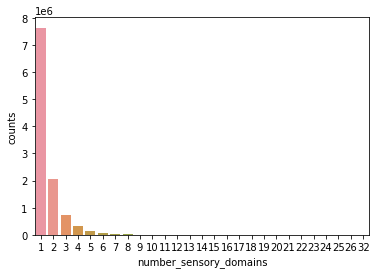

In [11]:
sns.barplot(data=count_gene_id, x="number_sensory_domains", y="counts")#, hue="sex")

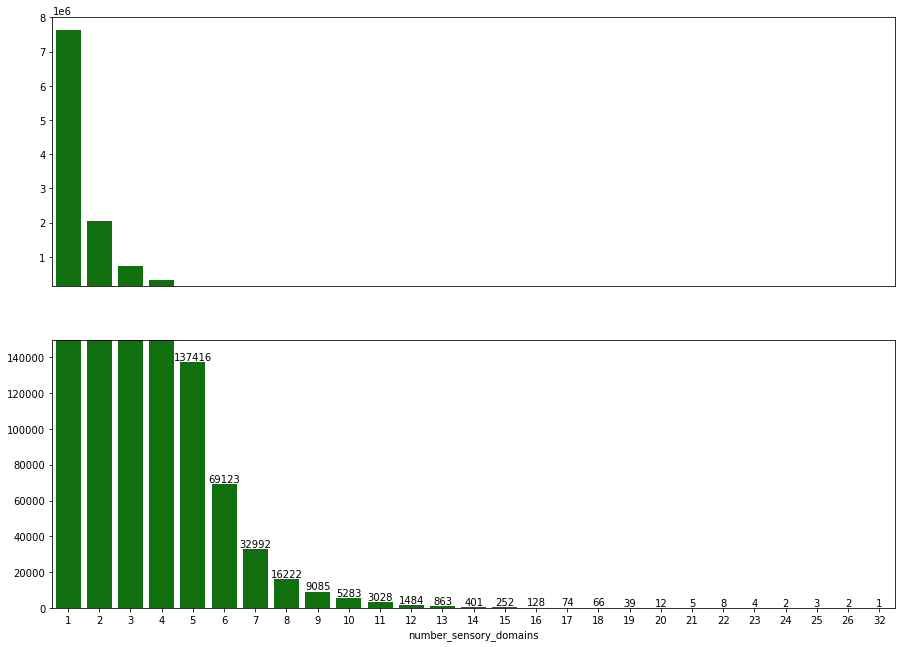

In [57]:
f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2,
                             sharex=True)
ax1 = sns.barplot(x="number_sensory_domains", y="counts",
                  data=count_gene_id, ax=ax1, color='green')
ax2 = sns.barplot(x="number_sensory_domains", y="counts",
                  data=count_gene_id, ax=ax2, color='green')
ax1.set_ylim(150000, 8000000) 
ax2.set_ylim(0, 150000)

ax1.get_xaxis().set_visible(False)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

f.subplots_adjust(left=0.15, right=2.1, bottom=0.15, top=2.2)

ax2.bar_label(ax2.containers[0])


plt.show()

# Figure: num(clusters)/pfam

In [5]:
#clustered_a=pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0_clustered_100_metagenomes.csv')
clustered_a=pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/clustered_mode_0_saved.csv')

In [6]:
clustered_a.head()

,Unnamed: 0,bar,pfam_predicted,pfam,gene_predicted,gene_oid
0,0,0,pfam13188,pfam13188,CVPL005L_100016672,CVPL005L_100016672
1,1,0,pfam13188,pfam13188,CVPL005L_100016672,CVPL005L_100011619
2,2,0,pfam13188,pfam13188,CVPL005L_100016672,CVPL005W_10005012
3,3,0,pfam13188,pfam13188,CVPL005L_100016672,CVPL010W_100011399
4,4,0,pfam13188,pfam13188,CVPL005L_100016672,CVPL010W_100046382


In [10]:
clustered_a = clustered_a[['label_sensory', 'biome', 'bar']].drop_duplicates()
clustered_a = clustered_a.reset_index(drop=True)
#clustered_a['gene_oid'] =  clustered_a['label_sensory'].str.split('-').str[1]
clustered_a['Pfam'] =  clustered_a['label_sensory'].str.split('-').str[0]
for_figure = clustered_a[['bar', 'pfam', 'gene_oid']].reset_index(drop=True)
for_figure.head()

,bar,pfam,gene_oid
0,0,pfam13188,CVPL005L_100016672
1,0,pfam13188,CVPL005L_100011619
2,0,pfam13188,CVPL005W_10005012
3,0,pfam13188,CVPL010W_100011399
4,0,pfam13188,CVPL010W_100046382


In [43]:
pfam = for_figure.groupby('pfam')['bar'].nunique()

In [44]:
pfam = pd.DataFrame(pfam).reset_index()
pfam = pfam.sort_values('bar', ascending=False)

In [45]:
pfam = pfam.reset_index(drop=True)
pfam[pfam.bar<203].bar.sum()

1660

In [46]:
pfam = pfam.reset_index(drop=True)
concat = pd.Series({'pfam':'bottom 20 pfam','bar':1660})
pfam = pd.concat([pfam,concat.to_frame().T],ignore_index=True)

In [47]:
pfam = pfam.sort_values('bar', ascending=False)
pfam = pfam.reset_index(drop=False)

In [50]:
pfam = pfam[pfam.bar>203]
pfam = pfam.sort_values('index', ascending=True)

In [51]:
pfam

,index,pfam,bar
0,0,pfam13426,29185
1,1,pfam08448,20428
2,2,pfam00989,15981
3,3,pfam13185,15421
4,4,pfam13188,15110
5,5,pfam01590,14337
6,6,pfam13492,9655
7,7,pfam08447,9349
8,8,pfam07494,7061
9,9,pfam02743,2752


<AxesSubplot:xlabel='bar', ylabel='pfam'>

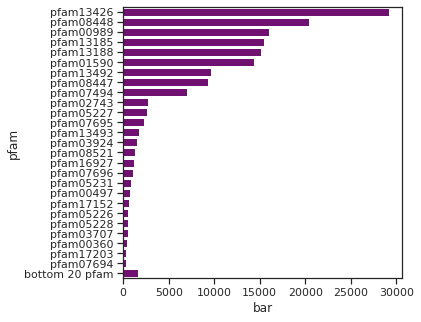

In [72]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks")
#sns.set_context("paper")
#sns.set_theme(style="whitegrid")
sns.color_palette("bright")
sns.barplot(data=pfam, x="bar", y="pfam", color='purple', 
           )#, hue="sex")

In [73]:
pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/all_clusters_113k/copy_matrix_ready_1.csv',nrows=5)

,Unnamed: 0,GOLD Analysis Project ID,index,244.0,860.0,1073.0,1213.0,2135.0,3240.0,3366.0,...,78145.0,84461.0,87784.0,112026.0,18940.0,24723.0,38955.0,59349.0,99546.0,111516.0
0,0,Ga0501123,gene_copy,7.0,280.0,56.0,392.0,23.0,13.0,117.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Ga0526455,gene_copy,0.0,28.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Ga0497336,gene_copy,0.0,209.0,0.0,0.0,0.0,0.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Ga0502774,gene_copy,0.0,1175.0,0.0,87.0,0.0,0.0,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Ga0506522,gene_copy,0.0,4.0,0.0,0.0,3.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section where explore clusters in each biome
* find the clusters in feature selection
* typically blastp these amino acid sequences to find their identity or context

In [2]:
clustered_a=pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0_clustered_100_metagenomes.csv')
clustered_a = clustered_a[['label_sensory', 'biome', 'bar']]
clustered_a['gene_oid'] =  clustered_a['label_sensory'].str.split('-').str[1]
clustered_a['sensory_aa'] =  clustered_a['label_sensory'].str.split('-').str[2]
_biome ='Host-associated:Mammals: Human:Large intestine'

clustered_a = clustered_a[clustered_a.biome == _biome].reset_index(drop=True)
clustered_a.head()

,label_sensory,biome,bar,gene_oid,sensory_aa
0,pfam08448-Ga0243760_100002443-RVADGFIVLTVDGIVR...,Host-associated:Mammals: Human:Large intestine,94814.0,Ga0243760_100002443,RVADGFIVLTVDGIVRYASPNAISCFRRLGSVSTMQGEYLSEIGTK...
1,pfam00497-Ga0243760_100011126-TIGFLPNDEPLSAFSS...,Host-associated:Mammals: Human:Large intestine,105074.0,Ga0243760_100011126,TIGFLPNDEPLSAFSSETNLPAGILPGIAKELERLSGARVILKLLP...
2,pfam00497-Ga0243760_100011126-RVGYTDSPGFIEKTAA...,Host-associated:Mammals: Human:Large intestine,81555.0,Ga0243760_100011126,RVGYTDSPGFIEKTAAGTVDGYGVAYLNEISHYTGWRYEYVYATWQ...
3,pfam08447-Ga0243760_100011274-AYISEELPGMFGYTME...,Host-associated:Mammals: Human:Large intestine,6368.0,Ga0243760_100011274,AYISEELPGMFGYTMEEFKKFTGNNAMGMVYPPDLPRALADCNECF...
4,pfam08447-Ga0243760_10001133-YYVNERMLAYLGYTYEE...,Host-associated:Mammals: Human:Large intestine,6368.0,Ga0243760_10001133,YYVNERMLAYLGYTYEEFVADTKGLVMNGIHPDDLERVEQIASRAM...


In [11]:
vic = clustered_a[clustered_a.bar == 102797]
print(vic.bar.value_counts())
#print(vic[vic.biome.str.contains('Human:L')].sensory_aa.value_counts())
#vic.biome.value_counts()[1:10]
vic.sensory_aa.value_counts()

102797.0    1211
Name: bar, dtype: int64


HVLCDPSRYPYSYNENGEMKGIIPDYFRKIADYAGISYEFLTPATRDEYIAYQKNKEVTNISIDARLETDNYAETKKWGLTAPFITMQLARVTRRDFDGEINVVATVDQTASNSIADAMAPGAEKLMCSTRQEMMEAVRKGKADAAFVYYYMAQAFVNSDTTGTMTYTLLEQPTFTYRMVVSSTENHALAGILTKAMYAMPQNLVEDLAARYTTY    42
HVLCDPTRYPYSYNENGEMKGIIPDYFRKIADYAGISYEFLTPVTRDEYIAYQKNKDTTDISIDARLETDNYAETKKWGITAPFITMQLARVTRRDFDGKINAVATVDQTVANSIADAMAPDAEKLMCSNRQEMMEAVRKGKADAAFVYYYMAQAFVNSDTTGTMTYTMLEQPTFTYRMVISSNENHALAGILTKAMYAMPQNLVEDLAAQYTTY    30
HVLCDPTRYPYSYNENGEMKGIIPDYFRKIADYAGISYEFLTPATRDEYIAYQKNKDITDISIDARLETDNYAETKKWGITAPFITMQLARVTRRDFDGKINAVATVDQTVANSIADAMAPDAEKLMCSTRQEMMEAVRKGKADAAFVYYYMAQAFVNSDTTGTMTYTMLEQPTFTYRMVISSNENHALAGILTKAMYAMPQNLVEDLAAQYTTY    25
TVLVNPDRYPYSYMTQDGVPTGIMVDIFQKAAGRARLRYKFLKPADRSEYKAMLADGQADFVIDLTDDMSQAENYGYKLTDSYLSAEFSWVLLRRHNGTLNNVAVAYDFSPSSLEMPGLGDTAHVEYLDSFDDCLAAVRAGTVDAYYTYTYQAERTVFDDTRNELRSMLSDEQRNFCIGVRQDYDVLLRTVLNKSIDSLTHAEISTITNAYIN      21
RVLCDPTREPYSFMENGEIKGILPDYFKELAKYAGLSYQFIPCRTREEYLALQEDESFDIAIDARIDEGTAESNHLGVTAPYITVRSAKVVRRDFDGEIQTVATADQSSSGS

In [12]:
df=pd.DataFrame(vic.biome.value_counts()).reset_index()
df.columns = ['biome','count']
df['%'] = df['count'] / df['count'].sum()*100
df

,biome,count,%
0,Host-associated:Mammals: Human:Oral cavity,1892,41.400438
1,Environmental:Terrestrial:Insects nest,427,9.343545
2,Engineered:Bioreactor:Unclassified,404,8.840263
3,Engineered:Built environment:Subway,288,6.301969
4,Host-associated:Mammals: Human:Large intestine,284,6.214442
...,...,...,...
73,Engineered:WWTP:Unclassified,1,0.021882
74,Engineered:WWTP:Algae cultivation tank,1,0.021882
75,"Environmental:Terrestrial:Peat, Wetlands",1,0.021882
76,Environmental:Aquatic:Creek,1,0.021882


# Make .fasta file for taxonomy of all gut biome proteins along with their disease states

In [2]:
check = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/pfam_amino_acid_all_study_together.csv',
            usecols = ['faa_sequence', 'GOLD Analysis Project ID', 'gene_copy',  'Ecosystem Type', 'Ecosystem Subtype', 
                    'Ecosystem Category', 'Specific Ecosystem', 'Ecosystem'])
check

,gene_copy,faa_sequence,GOLD Analysis Project ID,Ecosystem,Ecosystem Category,Ecosystem Subtype,Ecosystem Type,Specific Ecosystem
0,9,MLRNPLSRGAAAVATSAAPFVSGMLDQMPNSVLVFVGATKDLAYAN...,Ga0246665,Environmental,Aquatic,Lake,Freshwater,Unclassified
1,93,VHEIIIESPIAVVLLGAVILAIIYHIVMYFYNRDELLIHYLLYLFF...,Ga0453188,Environmental,Aquatic,Lake,Freshwater,Epilimnion
2,96,MKSKSNIITFIFIITALFLALISHLAFRNNLKNNVENFNSYHFLVD...,Ga0453188,Environmental,Aquatic,Lake,Freshwater,Epilimnion
3,96,MKSKSNIITFIFIITALFLALISHLAFRNNLKNNVENFNSYHFLVD...,Ga0453188,Environmental,Aquatic,Lake,Freshwater,Epilimnion
4,33,MKDRLRSDKAAGLQPMPSHHSLTADGALALAYLLGYLLIEAISFAQ...,Ga0453188,Environmental,Aquatic,Lake,Freshwater,Epilimnion
...,...,...,...,...,...,...,...,...
21984301,10,LEGFRAAVDAALRTGGEFEREYRVVRPDGETRWIAARGRVETGVGS...,Ga0003954,Host-associated,Plants,Rhizosphere,Roots,Unclassified
21984302,15,DVAADPDYVGLVTSSRSEVAVPILWGDEVVAVLNVERDTPGGFTPS...,Ga0003954,Host-associated,Plants,Rhizosphere,Roots,Unclassified
21984303,24,HFETERMRIDGSRILVSLTISPLRDDEGRVVGASKIVRDVTDRKRA...,Ga0003954,Host-associated,Plants,Rhizosphere,Roots,Unclassified
21984304,8,ALRETGYWRGENVHRKRNGERIHVESAVICLHDTAGEEIGFLATIR...,Ga0003954,Host-associated,Plants,Rhizosphere,Roots,Unclassified


In [4]:
cds = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
cds = cds[['GOLD', 'Disease']]
cds['GOLD Analysis Project ID'] = cds['GOLD']

check_2 = check[check['Ecosystem Category'].str.contains('Human')]
check_3 = check_2[check_2['Ecosystem Subtype'].str.contains('Large')]
check_3 = check_3.drop(['Ecosystem', 'Ecosystem Category', 'Ecosystem Type',
                        'Specific Ecosystem'], axis=1)
check_4 = check_3.merge(cds, on='GOLD Analysis Project ID', how='left')
check_4['name'] = check_4['Disease']+"-"+check_4['gene_copy'].astype(str)

/tmp/ipykernel_4479/1896749495.py:1: DtypeWarning: Columns (15,17,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  cds = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")


In [17]:
fasta = []
i=0
for aa in check_4.name:
    fasta.append(">%s\n%s" % (aa, check_4.faa_sequence[i]))
    i += 1
print(i)
df = pd.Series(fasta).to_csv(index=False)
pd.Series(df.replace('"', '')).to_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/disease_states.fasta", index=False)


492598


# More exploratory sections...

In [27]:
clustered_a = clustered_a.merge(blasted_hk, on='label_sensory', how='left')

In [8]:
blasted_hk = blasted_hk.merge(clustered_a, on='gene_oid', how='left')
blasted_hk = blasted_hk.drop('Unnamed: 0', axis=1)

In [6]:
ff = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/annotated_sensory_domains_with_bar.csv')

In [16]:
ff=ff.fillna(0)
#ff[ff.description.str.contains('Dos')].biome.value_counts()

vic = ff[ff.bar == 80647]
print(vic.bar.value_counts())

#vic['gene_oid'] = vic['label_sensory'].str.split('-').str[1]
#vic['aa'] = vic['label_sensory'].str.split('-').str[2]

df=pd.DataFrame(vic.biome.value_counts()).reset_index()
df.columns = ['biome','count']
df['%'] = df['count'] / df['count'].sum()*100
df[30:60]

80647.0    12860
Name: bar, dtype: int64


,biome,count,%
30,Environmental:Terrestrial:Contaminated,3,0.023328
31,Environmental:Terrestrial:Tundra,3,0.023328
32,Engineered:WWTP:Unclassified,3,0.023328
33,Engineered:Bioremediation:Unclassified,2,0.015552
34,Engineered:Modeled:Unclassified,2,0.015552
35,Environmental:Aquatic:Creek,2,0.015552
36,Engineered:Built environment:Unclassified,2,0.015552
37,Host-associated:Plants:Rhizosphere,2,0.015552
38,Environmental:Aquatic:River,1,0.007776
39,Environmental:Aquatic:Unclassified,1,0.007776


# Figures: plots not used in manuscript; for total unique clusters
1) showing # unique clusters vs. # total clusters have. dots are biomes, and color by something
2) showing the biomes vs. # of clusters 
3) count of the clusters vs. count of the proteins

In [6]:
# annotated file
clustered_a = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/annotated_all_expasy_with_bar_and_aa.csv')
clustered_a=clustered_a.drop('Unnamed: 0',axis=1)
clustered_a.head()
cds = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
cds = cds.groupby('biome').filter(lambda x : len(x) > 30)
uniques = pd.Series(cds.biome.drop_duplicates())
#filter to only our biomes
clustered_2 = clustered_a[clustered_a.biome.isin(uniques)]

In [ ]:
#1) need count of number of clusters in each biome
number_clusters = pd.DataFrame(clustered_2.groupby('biome')['bar'].nunique()).reset_index()
number_clusters.columns = ['biome', 'number_clusters']

In [36]:
# number of sensors in biome
number_clusters_0 = pd.DataFrame(clustered_2.groupby('biome')['bar'].count()).reset_index()
number_clusters_0.columns = ['biome', 'number_proteins']
number_clusters = number_clusters.merge(number_clusters_0,on='biome',how='left')

In [118]:
number_clusters = number_clusters[~number_clusters.biome.str.contains('Vagina')]
number_clusters = number_clusters[~number_clusters.biome.str.contains('Gills')]
number_clusters = number_clusters[~number_clusters.biome.str.contains('Air:Unclassified')]
number_clusters['colors'] = number_clusters.biome.str.split(':').str[0]
number_clusters_log = np.log2(number_clusters.drop(['biome','colors'], axis=1))
number_clusters_log['biome'] = number_clusters.biome
biome = number_clusters.biome+"::::::::::::"
number_clusters_log['biome_2'] = biome.str.split(':').str[1]+":"+biome.str.split(':').str[2]+biome.str.split(':').str[3]
number_clusters_log['colors'] = number_clusters_log.biome.str.split(':').str[1]

In [124]:
points=alt.Chart(number_clusters_log[number_clusters_log.biome.str.contains("Host")]).mark_circle(size=50).encode(
    x=alt.X('number_clusters', scale=alt.Scale(zero=False)),
    y=alt.Y('number_proteins', scale=alt.Scale(zero=False, padding=1)),
    color=alt.Color('colors', legend=alt.Legend(
        orient='none',
        legendX=130, legendY=-40,
        direction='horizontal',
        titleAnchor='middle')),
    tooltip='biome').properties(height=500,width=700)
text = points.mark_text(align='left',
    baseline='middle',
    dx=5,size=12,
    ).encode(text='biome_2')
points + text

alt.LayerChart(...)

In [94]:
sort = alt.SortField(field='number_clusters', 
                             order='descending')

base = alt.Chart(number_clusters).encode(
    alt.X('biome', sort=sort,axis=alt.Axis(title=None))).properties(width=1000)

line = base.mark_line(stroke='#5276A7', interpolate='monotone').encode(
    alt.Y('number_proteins',
          axis=alt.Axis(title='Count proteins', titleColor='#5276A7')))

area = base.mark_bar(opacity=0.3, color='#57A44C').encode(
    alt.Y('number_clusters',
          axis=alt.Axis(title='Unique Clusters', titleColor='#57A44C')),# alt.Y2('average(temp_min)')
)

alt.layer(area, line).resolve_scale(
    y = 'independent'
)

alt.LayerChart(...)

In [35]:
# number of unique sensors in a biome
clustered_grouped = pd.DataFrame(clustered_2.groupby(['bar'])['biome'].nunique()).reset_index()
clustered_grouped.columns = ['bar', 'bar_number_in_biome'] # number unique biomes
clustered_grouped = clustered_grouped[clustered_grouped.bar_number_in_biome < 2]

clustered_grouped = clustered_2.merge(clustered_grouped, how='left', on='bar')
clustered_grouped = clustered_grouped[clustered_grouped.bar_number_in_biome>0]
number_clusters_0 = pd.DataFrame(clustered_grouped.groupby('biome')['bar'].nunique()).reset_index()
number_clusters_0.columns = ['biome', 'number_unique_clusters']
number_clusters_0

,biome,number_unique_clusters
0,Environmental:Aquatic:Oceanic,1
1,Environmental:Terrestrial:Insects nest,1
2,Host-associated:Arthropoda: Insects:Gut,3
3,Host-associated:Mammals: Human:Large intestine,6
4,Host-associated:Mammals:Large intestine,1
5,Host-associated:Mammals:Stomach,1


# Tooth - saved Vick analysis
Vick protein
* find the biomes its in using the cluster index
* look at the # of unique proteins
* how to tell the differences between proteins?
* find the original HK proteins, see if they are different between biomes. Ideally do mmseq2 for HK proteins, recluster the clusters OR **taxonomic** for the cluster for **each biome** but first need the gene IDs to do that.

In [ ]:
#read in file
# annotated file
clustered_a = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/annotated_all_expasy_with_bar_and_aa.csv')
clustered_a=clustered_a.drop('Unnamed: 0',axis=1)
clustered_a.head()

#not annotated file
#clustered_a=pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0_clustered_100_metagenomes.csv')
#clustered_a = clustered_a.drop('Unnamed: 0',axis=1)


cds = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
cds = cds.groupby('biome').filter(lambda x : len(x) > 30)
uniques = pd.Series(cds.biome.drop_duplicates())
#filter to only our biomes
clustered_2 = clustered_a[clustered_a.biome.isin(uniques)]
clustered_2 = clustered_2.fillna(0)

In [52]:
vv = 'SILSYMTDGVLATDRRGKITVINDMAQKQLNVTREQALECNILD'
full_protein[full_protein.faa_sequence.str.contains(vv)]

,gene_oid,gene_copy,faa_sequence
12308020,Ga0105482_10106561,7,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12369693,Ga0115190_100002221,47,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12498002,Ga0119799_1012735,7,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12931722,Ga0105017_1021095,9,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13257061,Ga0099615_10001217,12,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13392702,Ga0119800_10012264,28,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13747802,Ga0119809_1000023173,16,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
14091893,Ga0103275_1000856,24,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
14135540,Ga0104764_1018021,9,THENLAQEKNRLTSILSYMTDGVLATDRRGKITVINDMAQKQLNVT...


In [29]:
vick = clustered_2[clustered_2.gene_name.str.contains('vicK').fillna(False)]
vick = vick[vick.bar == 30279]
print(vick.bar.value_counts())

vick['pfam'] = vick['label_sensory'].str.split('-').str[0]
vick['gene_oid'] = vick['label_sensory'].str.split('-').str[1]
vick['amino_acid'] = vick['label_sensory'].str.split('-').str[2]

df=pd.DataFrame(vick.biome.value_counts()).reset_index()
df.columns = ['biome','count']
df['%'] = df['count'] / df['count'].sum()*100
df[0:30]

30279.0    1936
Name: bar, dtype: int64


In [ ]:
biome_unique = pd.DataFrame(vick[['amino_acid','biome']].value_counts().reset_index())
biome_unique.columns = ['amino_acid','biome','counts']
biome_unique['%'] = biome_unique['counts'] / biome_unique['counts'].sum()*100
biome_unique[0:30]

# What are the full length amino acids for Vick? What is their taxonomic profile?

In [46]:
full_protein= pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/full_hk_amino_acid_sequence.csv")
full_protein = full_protein.drop('Unnamed: 0',axis=1)
full_protein.head()

,gene_oid,gene_copy,faa_sequence
0,Ga0246665_1642_2_577,9,MLRNPLSRGAAAVATSAAPFVSGMLDQMPNSVLVFVGATKDLAYAN...
1,Ga0453188_0000018_9739_11091,93,VHEIIIESPIAVVLLGAVILAIIYHIVMYFYNRDELLIHYLLYLFF...
2,Ga0453188_0000024_43626_45344,96,MKSKSNIITFIFIITALFLALISHLAFRNNLKNNVENFNSYHFLVD...
3,Ga0453188_0000117_24216_26216,33,MKDRLRSDKAAGLQPMPSHHSLTADGALALAYLLGYLLIEAISFAQ...
4,Ga0453188_0000190_2570_3895,79,MLEHERFARKQAEILLEEKSRLLDQANLELIQSSKALEREAKRTKA...


In [47]:
vv = 'SILSYMTDGVLATDRRGKITVINDMAQKQLNVTREQALECNILD'
full_protein[full_protein.faa_sequence.str.contains(vv)]

,gene_oid,gene_copy,faa_sequence
12308020,Ga0105482_10106561,7,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12369693,Ga0115190_100002221,47,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12498002,Ga0119799_1012735,7,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
12931722,Ga0105017_1021095,9,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13257061,Ga0099615_10001217,12,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13392702,Ga0119800_10012264,28,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
13747802,Ga0119809_1000023173,16,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
14091893,Ga0103275_1000856,24,MTNVFESSPLFLRILLAVLIILLFFYFIFLNYREYKNNNQVKQLNA...
14135540,Ga0104764_1018021,9,THENLAQEKNRLTSILSYMTDGVLATDRRGKITVINDMAQKQLNVT...


In [31]:
vick_merged = vick.merge(full_protein,on='gene_oid',how='left')

In [32]:
print(len(vick_merged))
#vick_merged['label_protein'] = vick_merged.pfam_id+"-"+vick_merged.gene_oid
vick_merged.head()

1936


,label_sensory,expasy_id,entry_name,description,gene_name,comments,biome,bar,pfam,gene_oid,amino_acid,gene_copy,faa_sequence
0,pfam00989-Ga0134779_101723-RLDSVITHMSDGILATDRR...,Q4LAJ8,WALK_STAHJ,RecName: Full=Sensor protein kinase WalK {ECO:...,Name=walK; Synonyms=vicK; OrderedLocusNames=SH...,['FUNCTION: Member of the two-component regula...,Host-associated:Mammals: Human:Skin,30279.0,pfam00989,Ga0134779_101723,RLDSVITHMSDGILATDRRGRVRIANDMALKMLGLAKEDVIGYYML...,14,MKWLKQLQSLHTKLVIVYVLLIIIGMQIIGLYFTNSLEKELLDNFK...
1,pfam13426-Ga0008109_102875831-DRRGRVRIINEMALKM...,Q4LAJ8,WALK_STAHJ,RecName: Full=Sensor protein kinase WalK {ECO:...,Name=walK; Synonyms=vicK; OrderedLocusNames=SH...,['FUNCTION: Member of the two-component regula...,Engineered:Bioreactor:Aerobic,30279.0,pfam13426,Ga0008109_102875831,DRRGRVRIINEMALKMLGLERADVEAKHILDILNIDDDYSLDDLQE...,9,TDRRGRVRIINEMALKMLGLERADVEAKHILDILNIDDDYSLDDLQ...
2,pfam13426-Ga0121570_1055331-RRGRIRIVNDMALKMLGM...,Q4LAJ8,WALK_STAHJ,RecName: Full=Sensor protein kinase WalK {ECO:...,Name=walK; Synonyms=vicK; OrderedLocusNames=SH...,['FUNCTION: Member of the two-component regula...,Engineered:Built environment:Subway,30279.0,pfam13426,Ga0121570_1055331,RRGRIRIVNDMALKMLGMAKEDIIGYYMLSVLSLEDEFKLEEIQEN...,2,DRRGRIRIVNDMALKMLGMAKEDIIGYYMLSVLSLEDEFKLEEIQE...
3,pfam13426-Ga0100238_1070161-GRVRIANDMALKMLGLAK...,Q4LAJ8,WALK_STAHJ,RecName: Full=Sensor protein kinase WalK {ECO:...,Name=walK; Synonyms=vicK; OrderedLocusNames=SH...,['FUNCTION: Member of the two-component regula...,Host-associated:Mammals: Human:Skin,30279.0,pfam13426,Ga0100238_1070161,GRVRIANDMALKMLGLAKEDVIGYYMLGVLNLENEFSLEEIQENSD...,27,RGRVRIANDMALKMLGLAKEDVIGYYMLGVLNLENEFSLEEIQENS...
4,pfam00989-Ga0115307_1000326-RLDSVITHMSDGILATDR...,Q4LAJ8,WALK_STAHJ,RecName: Full=Sensor protein kinase WalK {ECO:...,Name=walK; Synonyms=vicK; OrderedLocusNames=SH...,['FUNCTION: Member of the two-component regula...,Host-associated:Mammals: Human:Skin,30279.0,pfam00989,Ga0115307_1000326,RLDSVITHMSDGILATDRRGRVRIANDMALKMLGLAKEDVIGYYML...,23,MKWLKQLQSLHTKLVIVYVLLIIIGMQIIGLYFTNSLEKELLDNFK...


* next, make a fasta file for just the hk proteins for each biome
* repeat taxonomy for each of the top biomes

In [9]:
vick_merged_here = vic.reset_index(drop=True)
vic.head()

,biome,bar,faa_sequence,GOLD Analysis Project ID
12,Environmental:Aquatic:Lake,29054.0,VSAFEHAAAASSSELQRLLDAIIAVGSELSLPVVLRRITEAATSLV...,Ga0453188
437,Environmental:Aquatic:Lake,29054.0,MSSDGPGDGPHGEDQSSLLRETLSQLRLRELLVEVQDRVEQIVEGR...,Ga0453188
517,Environmental:Aquatic:Lake,29054.0,MSGDGAHGEDQSSRLRETLSQLRLRELLVEVQDRVEQIVEGRDKLD...,Ga0453188
1046,Environmental:Aquatic:Lake,29054.0,MLVVTSGLDLELTLQTIVESATKLVDARYGALGIRGEGREIVEFVL...,Ga0453188
1943,Environmental:Terrestrial:Peat,29054.0,MSSSQLTPNSSRDSTGLLGLREMSSALETWHLHPDPDGYEELSRAF...,Ga0494750


In [11]:
 #_biome = 'Host-associated:Mammals: Human:Oral cavity'
#_biome = 'Environmental:Terrestrial:Insects nest'
#_biome ='Engineered:Bioreactor:Unclassified'
#_biome ='Engineered:Built environment:Subway'
#_biome ='Host-associated:Mammals: Human:Large intestine'
#_biome ='Host-associated:Mammals: Human:Skin'

#vick_merged_here = vick_merged[vick_merged.biome == _biome].reset_index(drop=True)
vick_merged_here = vic.reset_index(drop=True)

fasta = []
i=0
for aa in vick_merged_here.bar:
    fasta.append(">%s\n%s" % (aa, vick_merged_here.faa_sequence[i]))
    i += 1
print(i)
df = pd.Series(fasta).to_csv(index=False)
pd.Series(df.replace('"', '')).to_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/dosRST_29054.fasta", index=False)

72914


In [56]:
cds = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv",
                  usecols=['Habitat','Isolation', 'GOLD', 'biome','Sample_Body_Subsite', 'Study'])
gold_ids = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/pfam_amino_acid_all_study_together.csv",
                       usecols=['gene_oid','GOLD Analysis Project ID'])
cds['GOLD Analysis Project ID'] = cds.GOLD
gold_ids = gold_ids.merge(cds, on='GOLD Analysis Project ID', how='left')

In [59]:
_biome = 'Host-associated:Mammals: Human:Oral cavity'
vick_merged_here = vick_merged[vick_merged.biome == _biome].reset_index(drop=True)
vick_merged_here = vick_merged_here[['gene_oid', 'amino_acid', 'gene_copy', 'faa_sequence']]
vick_merged_here = vick_merged_here.merge(gold_ids, on='gene_oid', how='left')

In [67]:
vick_merged_here = vick_merged_here.fillna(0)
vick_merged_here[1:2]

,gene_oid,amino_acid,gene_copy,faa_sequence,GOLD Analysis Project ID,GOLD,biome,Study,Habitat,Isolation,Sample_Body_Subsite
1,Ga0168978_1047193,RLSSILSYMTDGVLATNRRGQIIMINDMATKQLGVKESEARKMNIL...,9,MLQGKTFDVDELKQLYVKGAKSGIFDDERNGDYNFKNPEDVSLLHQ...,Ga0168978,Ga0168978,Host-associated:Mammals: Human:Oral cavity,Host-associated microbial communities from gut...,Host-associated,Human teeth,Teeth


In [98]:
vick_merged_here.species.value_counts()

Bacillales                                    1412
Mammaliicoccus sciuri                         326 
Bacillus subtilis subsp. subtilis str. 168    126 
Staphylococcaceae                             18  
unclassified                                  11  
Name: species, dtype: int64

In [81]:
vicky = pd.DataFrame(vick_merged_here[['Study','Sample_Body_Subsite']].value_counts().reset_index())
vicky.columns = ['Study','Sample_Body_Subsite','counts']
vicky.Study = vicky.Study.str.wrap(1000)
pd.set_option('display.max_colwidth', 0)
vicky.sort_values(['Study','counts'], ascending=False)

,Study,Sample_Body_Subsite,counts
3,"Human oral microbial communities from Los Angeles, CA, USA",Human subgingival plaque,81
5,"Human oral microbial communities from Beijing, Chi",human oral cavity,18
0,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Tongue dorsum,812
1,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Supragingival plaque,511
2,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Buccal mucosa,408
4,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Attached/Keratinized gingiva,20
6,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Subgingival plaque,16
7,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase","tiol Institutes of Health, USA",13
8,"Human microbial communities from the tiol Institute of Health, USA, HMP production phase",Hard palate,10
9,Host-associated microbial communities from gut and oral samples of Rheumatoid Arthritis patients in Chi,Teeth,3


In [64]:
vick_merged_here.Study.value_counts()

Human microbial communities from the tiol Institute of Health, USA, HMP production phase                   1790
Human oral microbial communities from Los Angeles, CA, USA                                                   81
Human oral microbial communities from Beijing, Chi                                                           18
Host-associated microbial communities from gut and oral samples of Rheumatoid Arthritis patients in Chi       4
Name: Study, dtype: int64

In [84]:
taxonomy = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/mmseqs/taxonomy_oral_cavity_Result.tsv',delimiter='\t',
            header=None,)
taxonomy.columns = ['gene_oid', 'x', 'type','species','taxonomy']

In [86]:
vick_merged_here = vick_merged_here.merge(taxonomy[['gene_oid','type','species']],on='gene_oid',how='left')

In [96]:
vicky = pd.DataFrame(vick_merged_here[['Sample_Body_Subsite','species']].value_counts().reset_index())
vicky.columns = ['Sample_Body_Subsite','species','counts']
pd.set_option('display.max_colwidth', 0)
vicky.sort_values(['counts'], ascending=False)[0:8]

,Sample_Body_Subsite,species,counts
0,Tongue dorsum,Bacillales,571
1,Supragingival plaque,Bacillales,460
2,Buccal mucosa,Bacillales,258
3,Buccal mucosa,Mammaliicoccus sciuri,142
4,Tongue dorsum,Mammaliicoccus sciuri,127
5,Tongue dorsum,Bacillus subtilis subsp. subtilis str. 168,97
6,Human subgingival plaque,Bacillales,64
7,Supragingival plaque,Mammaliicoccus sciuri,31
